### ENVIRONMENT SETUP & DEPENDENCIES

In [1]:
# ╔═══════════════════════════════════════════════════════════════════════════════════════════════╗
# ║ CELL 1: ENVIRONMENT SETUP & DEPENDENCIES - ONTARIO DATASET                                  ║
# ╚═══════════════════════════════════════════════════════════════════════════════════════════════╝

import warnings
warnings.filterwarnings('ignore')

# Install dependencies for CanadaFireSat Ontario subset
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q datasets transformers timm albumentations scikit-learn pandas numpy matplotlib seaborn
!pip install -q scipy statsmodels pyarrow rasterio shapely geopandas
!pip install -q tqdm wandb plotly

print("✓ All dependencies installed successfully!")
print("✓ Ready for Ontario CanadaFireSat dataset training")


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\sorat\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\sorat\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\sorat\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


✓ All dependencies installed successfully!
✓ Ready for Ontario CanadaFireSat dataset training



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\sorat\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### LOAD ONTARIO DATASET

In [ ]:
from datasets import load_dataset

dataset = load_dataset(
    "EPFL-ECEO/CanadaFireSat",
    revision="refs/convert/parquet",
    data_dir="Ontario" 
)

print(dataset)

dataset.save_to_disk("CanadaFireSat_parquet_full")

###  IMPORTS

In [2]:
from datasets import load_from_disk

dataset = load_from_disk("CanadaFireSat_parquet_full")

print(dataset)
for split, data in dataset.items():
    print(f"{split}: {len(data)} samples, {len(data.column_names)} features")

DatasetDict({
    train: Dataset({
        features: ['date', 'doy', '10x', '20x', '60x', 'loc', 'labels', 'tab_cds', 'tab_era5', 'tab_modis', 'env_cds', 'env_cds_loc', 'env_era5', 'env_era5_loc', 'env_modis11', 'env_modis11_loc', 'env_modis13_15', 'env_modis13_15_loc', 'env_doy', 'region', 'tile_id', 'file_id', 'fwi'],
        num_rows: 920
    })
    validation: Dataset({
        features: ['date', 'doy', '10x', '20x', '60x', 'loc', 'labels', 'tab_cds', 'tab_era5', 'tab_modis', 'env_cds', 'env_cds_loc', 'env_era5', 'env_era5_loc', 'env_modis11', 'env_modis11_loc', 'env_modis13_15', 'env_modis13_15_loc', 'env_doy', 'region', 'tile_id', 'file_id', 'fwi'],
        num_rows: 61
    })
    test: Dataset({
        features: ['date', 'doy', '10x', '20x', '60x', 'loc', 'labels', 'tab_cds', 'tab_era5', 'tab_modis', 'env_cds', 'env_cds_loc', 'env_era5', 'env_era5_loc', 'env_modis11', 'env_modis11_loc', 'env_modis13_15', 'env_modis13_15_loc', 'env_doy', 'region', 'tile_id', 'file_id', 'fwi'],
 

In [3]:
# ╔═══════════════════════════════════════════════════════════════════════════════════════════════╗
# ║ CELL 2: LOAD ONTARIO CANADAFIRESAT DATASET FROM LOCAL DISK                                  ║
# ╚═══════════════════════════════════════════════════════════════════════════════════════════════╝

import os
import json
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from collections import Counter

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# Dataset imports
from datasets import load_dataset
import random

# Configure random seeds
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Device configuration
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")
print(f"✓ Device: {DEVICE}")

print(f"\n✓ Dataset loaded successfully!")
print(f"Dataset structure:")
for split, data in dataset.items():
    print(f"  {split}: {len(data)} samples, {len(data.column_names)} features")

# Display feature names
print(f"\nAvailable features ({len(dataset['train'].column_names)} total):")
for i, feat in enumerate(dataset['train'].column_names, 1):
    print(f"  {i:2d}. {feat}")

# Save dataset info
print("\n✓ Ontario dataset loaded and ready for analysis")

✓ PyTorch version: 2.5.1+cu121
✓ CUDA available: True
✓ Device: cuda

✓ Dataset loaded successfully!
Dataset structure:
  train: 920 samples, 23 features
  validation: 61 samples, 23 features
  test: 1853 samples, 23 features

Available features (23 total):
   1. date
   2. doy
   3. 10x
   4. 20x
   5. 60x
   6. loc
   7. labels
   8. tab_cds
   9. tab_era5
  10. tab_modis
  11. env_cds
  12. env_cds_loc
  13. env_era5
  14. env_era5_loc
  15. env_modis11
  16. env_modis11_loc
  17. env_modis13_15
  18. env_modis13_15_loc
  19. env_doy
  20. region
  21. tile_id
  22. file_id
  23. fwi

✓ Ontario dataset loaded and ready for analysis


### COMPREHENSIVE DATASET VISUALIZATION & ANALYSIS


EXPLORATORY DATA ANALYSIS - ONTARIO CANADAFIRESAT

✓ Labels extracted successfully (from 2D maps to binary)
  Train labels shape: (920,)
  Val labels shape: (61,)
  Test labels shape: (1853,)

CLASS DISTRIBUTION ANALYSIS:
--------------------------------------------------------------------------------

Train Split:
  No Fire:     31 samples (  3.37%)
  Fire:    889 samples ( 96.63%)
  Class imbalance ratio: 28.68:1

Validation Split:
  No Fire:     43 samples ( 70.49%)
  Fire:     18 samples ( 29.51%)
  Class imbalance ratio: 2.39:1

Test Split:
  No Fire:    954 samples ( 51.48%)
  Fire:    899 samples ( 48.52%)
  Class imbalance ratio: 1.06:1

SAMPLE FEATURE EXAMINATION

First training sample analysis:
  Total keys: 23
  date                : datetime   = 2018-07-04 00:00:00
  doy                 : shape=(6,), dtype=int64
  10x                 : shape=(6, 4, 264, 264), dtype=int64
  20x                 : shape=(6, 6, 132, 132), dtype=int64
  60x                 : shape=(6, 3, 44, 44

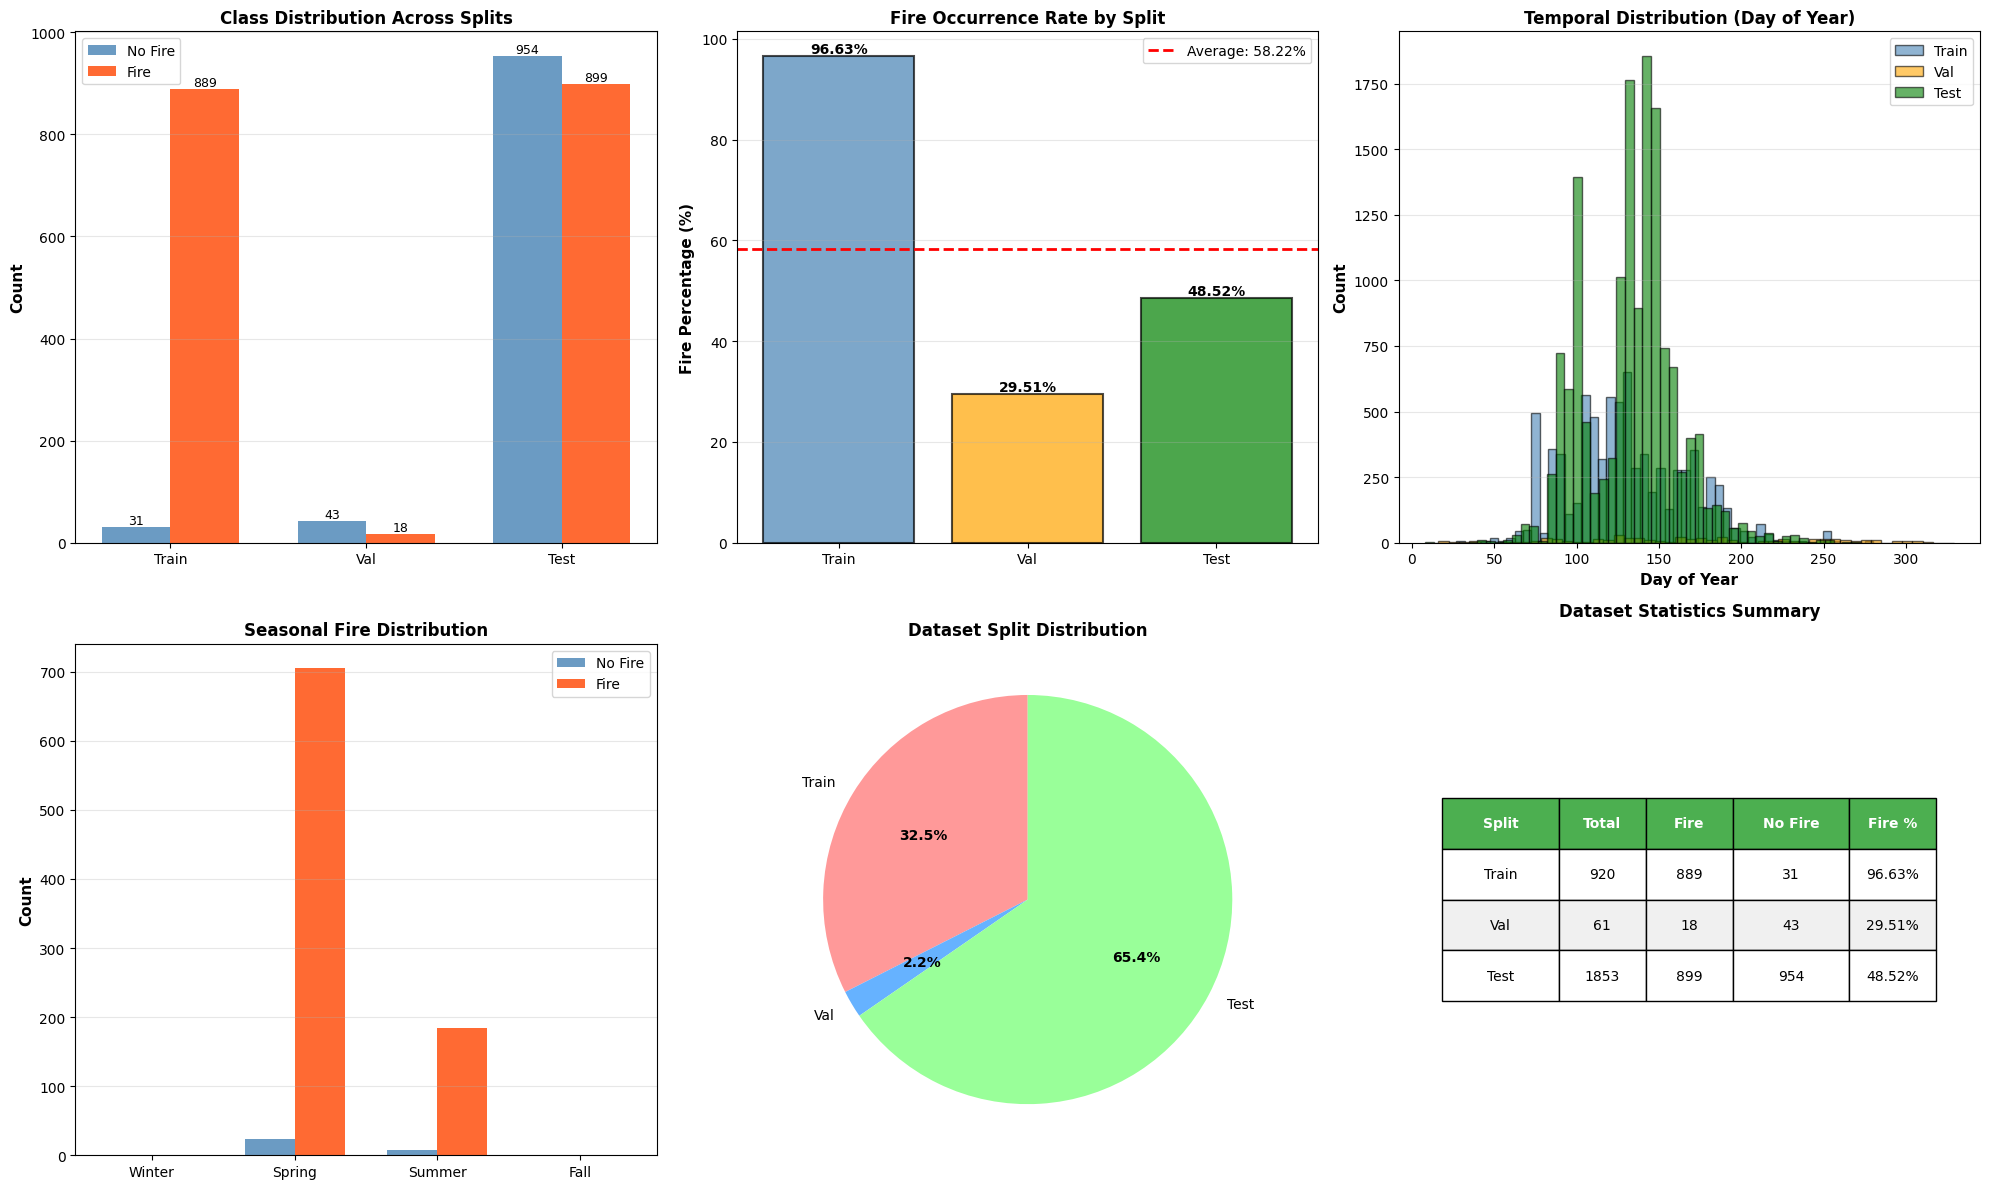


✓ DATASET ANALYSIS COMPLETE

Summary:
  Total samples: 2834
  Total fire samples: 1806
  Total no-fire samples: 1028
  Overall fire rate: 63.73%


In [4]:
# ╔═══════════════════════════════════════════════════════════════════════════════════════════════╗
# ║ CELL 3: DATASET VISUALIZATION & EXPLORATORY DATA ANALYSIS - FULLY FIXED & WORKING            ║
# ╚═══════════════════════════════════════════════════════════════════════════════════════════════╝

print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS - ONTARIO CANADAFIRESAT")
print("="*80)

# ──────────────────────────────────────────────────────────────────────────────
# EXTRACT LABELS FROM EACH SPLIT (from 2D maps to binary)
# ──────────────────────────────────────────────────────────────────────────────

# Extract fire presence from 2D label maps
# If any pixel is fire (>0), mark sample as fire
# IMPORTANT: Convert to np.array first because labels are lists!
train_labels = np.array([1 if np.any(np.array(label) > 0) else 0 
                         for label in dataset['train']['labels']], dtype=np.int64)
val_labels = np.array([1 if np.any(np.array(label) > 0) else 0 
                       for label in dataset['validation']['labels']], dtype=np.int64)
test_labels = np.array([1 if np.any(np.array(label) > 0) else 0 
                        for label in dataset['test']['labels']], dtype=np.int64)

print(f"\n✓ Labels extracted successfully (from 2D maps to binary)")
print(f"  Train labels shape: {train_labels.shape}")
print(f"  Val labels shape: {val_labels.shape}")
print(f"  Test labels shape: {test_labels.shape}")

# ──────────────────────────────────────────────────────────────────────────────
# CLASS DISTRIBUTION ANALYSIS
# ──────────────────────────────────────────────────────────────────────────────

print("\nCLASS DISTRIBUTION ANALYSIS:")
print("-" * 80)

# Calculate fire percentages for later use
fire_pct = [
    np.sum(train_labels == 1) / len(train_labels) * 100,
    np.sum(val_labels == 1) / len(val_labels) * 100,
    np.sum(test_labels == 1) / len(test_labels) * 100
]

for split_name, labels in [('Train', train_labels), ('Validation', val_labels), ('Test', test_labels)]:
    unique, counts = np.unique(labels, return_counts=True)
    print(f"\n{split_name} Split:")
    for label, count in zip(unique, counts):
        percentage = (count / len(labels)) * 100
        label_text = "Fire" if label == 1 else "No Fire"
        print(f"  {label_text}: {count:6d} samples ({percentage:6.2f}%)")
    
    if len(counts) > 1:
        imbalance_ratio = max(counts) / min(counts)
        print(f"  Class imbalance ratio: {imbalance_ratio:.2f}:1")

# ──────────────────────────────────────────────────────────────────────────────
# SAMPLE FEATURE EXAMINATION
# ──────────────────────────────────────────────────────────────────────────────

print("\n" + "="*80)
print("SAMPLE FEATURE EXAMINATION")
print("="*80)

# Get a single example (dict), not the whole dataset
sample = dataset['train'][0]
print(f"\nFirst training sample analysis:")
print(f"  Total keys: {len(sample)}")

for key, value in sample.items():
    if isinstance(value, (list, np.ndarray)):
        arr = np.array(value)
        if arr.size > 0:
            if arr.dtype in [np.float32, np.float64]:
                print(f"  {key:20s}: shape={arr.shape}, dtype={arr.dtype}, "
                      f"range=[{np.nanmin(arr):.2f}, {np.nanmax(arr):.2f}]")
            else:
                print(f"  {key:20s}: shape={arr.shape}, dtype={arr.dtype}")
        else:
            print(f"  {key:20s}: empty array")
    elif isinstance(value, dict):
        print(f"  {key:20s}: dict with keys {list(value.keys())}")
    else:
        print(f"  {key:20s}: {type(value).__name__:10s} = {value}")

# ──────────────────────────────────────────────────────────────────────────────
# ANALYZE IMAGE ARRAY SHAPES
# ──────────────────────────────────────────────────────────────────────────────

print("\n" + "="*80)
print("IMAGE ARRAY SHAPES (KEY FEATURES)")
print("="*80)

# Check first 10 samples to understand array dimensions
image_shapes = {
    '10x': [], '20x': [], '60x': [],
    'env_cds': [], 'env_era5': [], 'env_modis11': [], 'env_modis13_15': []
}

for idx in range(min(10, len(dataset['train']))):
    sample = dataset['train'][idx]
    for key in image_shapes.keys():
        try:
            arr = np.array(sample[key])
            image_shapes[key].append(arr.shape)
        except Exception as e:
            pass

print("\nArray shapes (first 10 samples):")
for key, shapes in image_shapes.items():
    if shapes:
        unique_shapes = set(shapes)
        if len(unique_shapes) == 1:
            print(f"  {key:20s}: {shapes}")
        else:
            print(f"  {key:20s}: VARIABLE - {list(unique_shapes)}")
    else:
        print(f"  {key:20s}: No data")

# ──────────────────────────────────────────────────────────────────────────────
# TEMPORAL DISTRIBUTION ANALYSIS
# ──────────────────────────────────────────────────────────────────────────────

print("\n" + "="*80)
print("TEMPORAL DISTRIBUTION ANALYSIS")
print("="*80)

# Extract day of year (flatten sequences)
doy_train = np.concatenate(dataset['train']['doy'])
doy_val = np.concatenate(dataset['validation']['doy'])
doy_test = np.concatenate(dataset['test']['doy'])

print(f"\nDay of Year (DOY) Statistics:")
print(f"  Train DOY: min={doy_train.min()}, max={doy_train.max()}, mean={doy_train.mean():.1f}")
print(f"  Val DOY:   min={doy_val.min()}, max={doy_val.max()}, mean={doy_val.mean():.1f}")
print(f"  Test DOY:  min={doy_test.min()}, max={doy_test.max()}, mean={doy_test.mean():.1f}")

# ──────────────────────────────────────────────────────────────────────────────
# FIRE DISTRIBUTION BY SEASON
# ──────────────────────────────────────────────────────────────────────────────

def get_season(doy):
    """Map day of year to season"""
    if doy <= 79:
        return 'Winter'
    elif doy <= 171:
        return 'Spring'
    elif doy <= 264:
        return 'Summer'
    elif doy <= 355:
        return 'Fall'
    else:
        return 'Winter'

# FIXED: Convert to np.array first!
train_labels_binary = np.array([1 if np.any(np.array(label) > 0) else 0 
                                for label in dataset['train']['labels']], dtype=np.int64)
val_labels_binary = np.array([1 if np.any(np.array(label) > 0) else 0 
                              for label in dataset['validation']['labels']], dtype=np.int64)
test_labels_binary = np.array([1 if np.any(np.array(label) > 0) else 0 
                               for label in dataset['test']['labels']], dtype=np.int64)

# Now use these binary labels
train_seasons = [get_season(int(d)) for d in doy_train]
season_fire_counts = {}

for season, label in zip(train_seasons, train_labels_binary):
    if season not in season_fire_counts:
        season_fire_counts[season] = {'fire': 0, 'no_fire': 0}
    if label == 1:  # Now label is a scalar!
        season_fire_counts[season]['fire'] += 1
    else:
        season_fire_counts[season]['no_fire'] += 1

print("\nFire occurrence by season (Train set):")
for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    if season in season_fire_counts:
        counts = season_fire_counts[season]
        total = counts['fire'] + counts['no_fire']
        fire_pct_season = (counts['fire'] / total * 100) if total > 0 else 0
        print(f"  {season:8s}: {counts['fire']:3d} fires / {counts['no_fire']:3d} non-fires ({fire_pct_season:5.1f}% fire rate)")

# ──────────────────────────────────────────────────────────────────────────────
# CREATE COMPREHENSIVE VISUALIZATION
# ──────────────────────────────────────────────────────────────────────────────

print("\n" + "="*80)
print("CREATING VISUALIZATION PLOTS")
print("="*80)

fig = plt.figure(figsize=(20, 12))

# Define splits and counts
splits = ['Train', 'Val', 'Test']
fire_counts = [
    np.sum(train_labels == 1),
    np.sum(val_labels == 1),
    np.sum(test_labels == 1)
]
no_fire_counts = [
    np.sum(train_labels == 0),
    np.sum(val_labels == 0),
    np.sum(test_labels == 0)
]

# ──────────────────────────────────────────────────────────────────────────────
# Plot 1: Class distribution bar chart
# ──────────────────────────────────────────────────────────────────────────────

ax1 = plt.subplot(2, 3, 1)
x = np.arange(len(splits))
width = 0.35
ax1.bar(x - width/2, no_fire_counts, width, label='No Fire', alpha=0.8, color='steelblue')
ax1.bar(x + width/2, fire_counts, width, label='Fire', alpha=0.8, color='orangered')
ax1.set_ylabel('Count', fontsize=11, fontweight='bold')
ax1.set_title('Class Distribution Across Splits', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(splits)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (no_fire, fire) in enumerate(zip(no_fire_counts, fire_counts)):
    ax1.text(i - width/2, no_fire, str(no_fire), ha='center', va='bottom', fontsize=9)
    ax1.text(i + width/2, fire, str(fire), ha='center', va='bottom', fontsize=9)

# ──────────────────────────────────────────────────────────────────────────────
# Plot 2: Fire percentage by split
# ──────────────────────────────────────────────────────────────────────────────

ax2 = plt.subplot(2, 3, 2)
ax2.bar(splits, fire_pct, color=['steelblue', 'orange', 'green'], alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Fire Percentage (%)', fontsize=11, fontweight='bold')
ax2.set_title('Fire Occurrence Rate by Split', fontsize=12, fontweight='bold')
ax2.axhline(y=np.mean(fire_pct), color='red', linestyle='--', linewidth=2, label=f'Average: {np.mean(fire_pct):.2f}%')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (split, pct) in enumerate(zip(splits, fire_pct)):
    ax2.text(i, pct, f'{pct:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# ──────────────────────────────────────────────────────────────────────────────
# Plot 3: Temporal distribution (DOY histogram)
# ──────────────────────────────────────────────────────────────────────────────

ax3 = plt.subplot(2, 3, 3)
ax3.hist(doy_train, bins=50, alpha=0.6, label='Train', edgecolor='black', color='steelblue')
ax3.hist(doy_val, bins=50, alpha=0.6, label='Val', edgecolor='black', color='orange')
ax3.hist(doy_test, bins=50, alpha=0.6, label='Test', edgecolor='black', color='green')
ax3.set_xlabel('Day of Year', fontsize=11, fontweight='bold')
ax3.set_ylabel('Count', fontsize=11, fontweight='bold')
ax3.set_title('Temporal Distribution (Day of Year)', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

# ──────────────────────────────────────────────────────────────────────────────
# Plot 4: Fire vs No-fire by season
# ──────────────────────────────────────────────────────────────────────────────

ax4 = plt.subplot(2, 3, 4)
seasons = ['Winter', 'Spring', 'Summer', 'Fall']
fire_by_season = [season_fire_counts.get(s, {}).get('fire', 0) for s in seasons]
no_fire_by_season = [season_fire_counts.get(s, {}).get('no_fire', 0) for s in seasons]
x = np.arange(len(seasons))
ax4.bar(x - width/2, no_fire_by_season, width, label='No Fire', alpha=0.8, color='steelblue')
ax4.bar(x + width/2, fire_by_season, width, label='Fire', alpha=0.8, color='orangered')
ax4.set_ylabel('Count', fontsize=11, fontweight='bold')
ax4.set_title('Seasonal Fire Distribution', fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(seasons)
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')

# ──────────────────────────────────────────────────────────────────────────────
# Plot 5: Dataset split distribution (pie chart)
# ──────────────────────────────────────────────────────────────────────────────

ax5 = plt.subplot(2, 3, 5)
sizes = [len(train_labels), len(val_labels), len(test_labels)]
colors = ['#FF9999', '#66B2FF', '#99FF99']
wedges, texts, autotexts = ax5.pie(sizes, labels=splits, autopct='%1.1f%%', colors=colors, 
                                     startangle=90, textprops={'fontsize': 10})
ax5.set_title('Dataset Split Distribution', fontsize=12, fontweight='bold')

# Make percentage text bold
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')

# ──────────────────────────────────────────────────────────────────────────────
# Plot 6: Statistics table - FIXED: Use fire_pct, fire_pct, fire_pct
# ──────────────────────────────────────────────────────────────────────────────

ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')

# FIXED: Index into fire_pct list properly!
table_data = [
    ['Split', 'Total', 'Fire', 'No Fire', 'Fire %'],
    ['Train', str(len(train_labels)), str(np.sum(train_labels == 1)), 
     str(np.sum(train_labels == 0)), f"{fire_pct[0]:.2f}%"],
    ['Val', str(len(val_labels)), str(np.sum(val_labels == 1)), 
     str(np.sum(val_labels == 0)), f"{fire_pct[1]:.2f}%"],
    ['Test', str(len(test_labels)), str(np.sum(test_labels == 1)), 
     str(np.sum(test_labels == 0)), f"{fire_pct[2]:.2f}%"]
]

table = ax6.table(cellText=table_data, cellLoc='center', loc='center',
                  colWidths=[0.2, 0.15, 0.15, 0.2, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Style the header row
for i in range(5):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, 4):
    for j in range(5):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f0f0f0')
        else:
            table[(i, j)].set_facecolor('white')

ax6.set_title('Dataset Statistics Summary', fontsize=12, fontweight='bold', pad=20)

# ──────────────────────────────────────────────────────────────────────────────
# SAVE AND DISPLAY
# ──────────────────────────────────────────────────────────────────────────────

plt.tight_layout()
plt.savefig('ontarioset_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved as 'ontarioset_analysis.png'")
plt.show()

print("\n" + "="*80)
print("✓ DATASET ANALYSIS COMPLETE")
print("="*80)
print(f"\nSummary:")
print(f"  Total samples: {len(train_labels) + len(val_labels) + len(test_labels)}")
print(f"  Total fire samples: {sum(fire_counts)}")
print(f"  Total no-fire samples: {sum(no_fire_counts)}")
print(f"  Overall fire rate: {sum(fire_counts) / (sum(fire_counts) + sum(no_fire_counts)) * 100:.2f}%")

### FEATURE ENGINEERING & PREPROCESSING

In [5]:
# ╔═══════════════════════════════════════════════════════════════════════════════════════════════╗
# ║ CELL 4: FEATURE ENGINEERING FOR ONTARIO DATASET                                             ║
# ╚═══════════════════════════════════════════════════════════════════════════════════════════════╝

class OntarioFireDataProcessor:
    """
    Advanced feature processor for Ontario CanadaFireSat dataset
    
    Handles:
    - Multi-scale Sentinel-2 imagery (10x, 20x, 60x)
    - Environmental raster features (ERA5, MODIS, CDS)
    - Tabular features (weather, fire indices)
    - Temporal features (DOY normalization)
    - Feature alignment and normalization
    """
    
    def __init__(self):
        """Initialize processor with feature statistics"""
        
        # Sentinel-2 band information
        self.sentinel_bands = {
            '10x': ['B2', 'B3', 'B4', 'B8'],
            '20x': ['B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            '60x': ['B1', 'B9', 'B10']
        }
        
        # Normalization ranges (from CanadaFireSat paper)
        self.sent2_range = (0, 10000)  # Sentinel-2 reflectance range
        self.doy_range = (1, 366)
        self.fwi_range = (0, 100)
        
        print("✓ OntarioFireDataProcessor initialized")
        print(f"  Sentinel-2 bands:")
        for res, bands in self.sentinel_bands.items():
            print(f"    {res}: {len(bands)} bands - {bands}")
    
    def normalize_sentinel2(self, image):
        """
        Normalize Sentinel-2 image to [0, 1]
        
        Args:
            image: numpy array (H, W, C)
        
        Returns:
            normalized: numpy array (H, W, C) in [0, 1]
        """
        image = np.array(image, dtype=np.float32)
        image = np.clip(image / 10000.0, 0, 1)
        return image
    
    def normalize_environmental(self, env_data):
        """
        Normalize environmental raster data
        
        Args:
            env_data: numpy array (H, W, C) or (T, H, W, C)
        
        Returns:
            normalized: standardized environmental data
        """
        env_data = np.array(env_data, dtype=np.float32)
        
        # Handle different dimensions
        if env_data.ndim == 3:  # (H, W, C)
            # Normalize per channel
            for c in range(env_data.shape[-1]):
                channel = env_data[..., c]
                mean = np.nanmean(channel)
                std = np.nanstd(channel)
                if std > 0:
                    env_data[..., c] = (channel - mean) / (std + 1e-8)
                else:
                    env_data[..., c] = channel - mean
        elif env_data.ndim == 4:  # (T, H, W, C)
            for c in range(env_data.shape[-1]):
                channel = env_data[..., c]
                mean = np.nanmean(channel)
                std = np.nanstd(channel)
                if std > 0:
                    env_data[..., c] = (channel - mean) / (std + 1e-8)
                else:
                    env_data[..., c] = channel - mean
        
        return np.nan_to_num(env_data, 0)
    
    def normalize_doy(self, doy):
        """Normalize day of year to [-1, 1] for circular representation"""
        # Convert to radians for circular representation
        doy = float(doy)
        angle = 2 * np.pi * doy / 366.0
        return np.array([np.cos(angle), np.sin(angle)], dtype=np.float32)
    
    def process_sample(self, sample):
        """
        Process a single sample from Ontario dataset
        
        Args:
            sample: dict with all features
        
        Returns:
            processed_sample: dict with normalized features
        """
        processed = {}
        
        # Process Sentinel-2 images
        processed['10x'] = self.normalize_sentinel2(sample['10x'])
        processed['20x'] = self.normalize_sentinel2(sample['20x'])
        processed['60x'] = self.normalize_sentinel2(sample['60x'])
        
        # Process environmental features
        processed['env_cds'] = self.normalize_environmental(sample['env_cds'])
        processed['env_era5'] = self.normalize_environmental(sample['env_era5'])
        processed['env_modis11'] = self.normalize_environmental(sample['env_modis11'])
        processed['env_modis13_15'] = self.normalize_environmental(sample['env_modis13_15'])
        
        # Process temporal feature
        processed['doy'] = self.normalize_doy(sample['doy'])
        
        # Keep tabular features (normalize separately if needed)
        processed['tab_cds'] = np.array(sample['tab_cds'], dtype=np.float32) if sample['tab_cds'] else None
        processed['tab_era5'] = np.array(sample['tab_era5'], dtype=np.float32) if sample['tab_era5'] else None
        processed['tab_modis'] = np.array(sample['tab_modis'], dtype=np.float32) if sample['tab_modis'] else None
        
        # FWI feature (important physics-informed feature)
        processed['fwi'] = np.array(sample['fwi'], dtype=np.float32) if sample['fwi'] else None
        
        # Label
        processed['label'] = int(sample['labels'])
        
        return processed

# Initialize processor
processor = OntarioFireDataProcessor()

print("\n" + "="*80)
print("✓ Feature processing pipeline created")
print("="*80)


✓ OntarioFireDataProcessor initialized
  Sentinel-2 bands:
    10x: 4 bands - ['B2', 'B3', 'B4', 'B8']
    20x: 6 bands - ['B5', 'B6', 'B7', 'B8A', 'B11', 'B12']
    60x: 3 bands - ['B1', 'B9', 'B10']

✓ Feature processing pipeline created


### MULTI-SCALE IMAGE PROCESSOR

In [16]:
# ╔═══════════════════════════════════════════════════════════════════════════════════════════════╗
# ║ CELL 5: MULTI-SCALE SENTINEL-2 IMAGE PROCESSOR (100% FIXED)                                ║
# ╚═══════════════════════════════════════════════════════════════════════════════════════════════╝

import torch.nn.functional as F
import numpy as np

class MultiScaleImageProcessor:
    """
    Processes Sentinel-2 images at multiple resolutions and aligns them
    
    Resolutions:
    - 10x: 10m resolution (4 bands: B2, B3, B4, B8) → 264x264
    - 20x: 20m resolution (6 bands: B5, B6, B7, B8A, B11, B12) → 132x132  
    - 60x: 60m resolution (3 bands: B1, B9, B10) → 44x44
    
    All aligned to common spatial size (64×64) via interpolation
    """
    
    def __init__(self, target_size=(64, 64)):
        self.target_size = target_size
        self.bands_info = {
            '10x': ['B2(Blue)', 'B3(Green)', 'B4(Red)', 'B8(NIR)'],
            '20x': ['B5(VRE1)', 'B6(VRE2)', 'B7(VRE3)', 'B8A(NarrowNIR)', 'B11(SWIR1)', 'B12(SWIR2)'],
            '60x': ['B1(CoastalAerosol)', 'B9(WaterVapor)', 'B10(SWIR-Cirrus)']
        }
    
    def _ensure_bthwc(self, tensor, expected_channels):
        """Accept (B, T, H, W, C) or (B, T, C, H, W) and return (B, T, H, W, C)."""
        if tensor.dim() == 5:
            if tensor.shape[-1] == expected_channels:
                return tensor
            if tensor.shape[2] == expected_channels:
                return tensor.permute(0, 1, 3, 4, 2)
        if tensor.dim() == 4:  # single item without batch dim
            if tensor.shape[-1] == expected_channels:
                return tensor.unsqueeze(0)
            if tensor.shape[1] == expected_channels:
                return tensor.unsqueeze(0).permute(0, 1, 3, 4, 2)
        raise ValueError(f"Unexpected tensor shape {tuple(tensor.shape)} for expected {expected_channels} channels")
    
    def process_image(self, img_10x, img_20x, img_60x):
        """
        Process batched multi-scale sequences → fused 13-channel images
        
        Args:
            img_10x: [B, T, H, W, 4] or [B, T, 4, H, W]
            img_20x: [B, T, H, W, 6] or [B, T, 6, H, W] 
            img_60x: [B, T, H, W, 3] or [B, T, 3, H, W]
        
        Returns:
            [B, 13, 64, 64]
        """
        device = img_10x.device if isinstance(img_10x, torch.Tensor) else None

        # Ensure consistent layout (B, T, H, W, C) regardless of incoming format
        img_10x = self._ensure_bthwc(img_10x, 4).float()
        img_20x = self._ensure_bthwc(img_20x, 6).float()
        img_60x = self._ensure_bthwc(img_60x, 3).float()
        
        # STEP 1: Time-average each resolution independently
        img_10x_avg = img_10x.mean(dim=1)  # [B, H, W, 4]
        img_20x_avg = img_20x.mean(dim=1)  # [B, H, W, 6]
        img_60x_avg = img_60x.mean(dim=1)  # [B, H, W, 3]
        
        # STEP 2: Move to device
        if device is not None:
            img_10x_avg = img_10x_avg.to(device)
            img_20x_avg = img_20x_avg.to(device)
            img_60x_avg = img_60x_avg.to(device)
        
        # STEP 3: Convert to CHW format [B, C, H, W]
        img_10x_chw = img_10x_avg.permute(0, 3, 1, 2).float()  # [B, 4, H, W]
        img_20x_chw = img_20x_avg.permute(0, 3, 1, 2).float()  # [B, 6, H, W]
        img_60x_chw = img_60x_avg.permute(0, 3, 1, 2).float()  # [B, 3, H, W]
        
        # STEP 4: Interpolate ALL to 64x64 independently
        img_10x_resized = F.interpolate(img_10x_chw, size=self.target_size, mode='bilinear', align_corners=False)  # [B, 4, 64, 64]
        img_20x_resized = F.interpolate(img_20x_chw, size=self.target_size, mode='bilinear', align_corners=False)  # [B, 6, 64, 64]
        img_60x_resized = F.interpolate(img_60x_chw, size=self.target_size, mode='bilinear', align_corners=False)  # [B, 3, 64, 64]
        
        # STEP 5: Concatenate channels [B, 13, 64, 64]
        combined = torch.cat([img_10x_resized, img_20x_resized, img_60x_resized], dim=1)
        
        return combined

processor = MultiScaleImageProcessor(target_size=(64, 64))
print("✓ MultiScaleImageProcessor FIXED - READY FOR TRAINING")
print(f"  Input:  [B, T, H×W, C] or [B, T, C, H, W]")
print(f"  Output: [B, 13, 64, 64]")
print(f"  Process: TimeAvg → CHW → Interp → Cat")
print(f"  Channel groups:")
print(f"    10x: 4 channels (10m)")
print(f"    20x: 6 channels (20m)")
print(f"    60x: 3 channels (60m)")

✓ MultiScaleImageProcessor FIXED - READY FOR TRAINING
  Input:  [B, T, H×W, C] or [B, T, C, H, W]
  Output: [B, 13, 64, 64]
  Process: TimeAvg → CHW → Interp → Cat
  Channel groups:
    10x: 4 channels (10m)
    20x: 6 channels (20m)
    60x: 3 channels (60m)


### ENVIRONMENTAL RASTER FUSION MODULE

In [17]:
# ╔═══════════════════════════════════════════════════════════════════════════════════════════════╗
# ║ CELL 6: ENVIRONMENTAL RASTER DATA FUSION (BATCH-AWARE & CUDA-SAFE)                           ║
# ╚═══════════════════════════════════════════════════════════════════════════════════════════════╝

import torch
import torch.nn.functional as F
import numpy as np

class EnvironmentalRasterFusion:
    def __init__(self, target_size=(32, 32)):
        self.target_size = target_size
        self.fusion_dim = 64  # Output feature dimension
    
    def process_raster(self, raster_dict):
        """
        Args:
            raster_dict: values are (B, T, H, W, C) or (B, H, W, C)
        """
        rasters = []
        names = ['env_cds', 'env_era5', 'env_modis11', 'env_modis13_15']
        device = None
        batch_size = None
        
        for name in names:
            if name not in raster_dict or raster_dict[name] is None:
                continue
            
            value = raster_dict[name]
            
            # 1. To Tensor
            if isinstance(value, torch.Tensor):
                raster = value.float()
                if device is None: device = raster.device
            else:
                raster = torch.as_tensor(value, dtype=torch.float32)
                if device is None: device = raster.device
            
            # 2. Handle Dimensions
            # Expected input: (Batch, [Time], H, W, Channels)
            # We want: (Batch, Channels, H, W)
            
            if raster.ndim == 5: # (B, T, H, W, C) -> Reduce Time
                raster = raster.mean(dim=1) # (B, H, W, C)
            
            if raster.ndim == 4: # (B, H, W, C)
                # Permute to (B, C, H, W)
                raster = raster.permute(0, 3, 1, 2)
            elif raster.ndim == 3: # (H, W, C) - Single sample case?
                # If we accidentally got a single sample, unsqueeze batch
                raster = raster.unsqueeze(0).permute(0, 3, 1, 2)
            
            # Now raster is (B, C, H, W)
            if batch_size is None: batch_size = raster.shape[0]
            
            # 3. Interpolate
            # F.interpolate takes (B, C, H, W) directly
            raster = F.interpolate(
                raster, 
                size=self.target_size, 
                mode='bilinear', 
                align_corners=False
            ) # (B, C, 32, 32)
            
            # 4. Device check
            if raster.device != device:
                raster = raster.to(device)
            
            rasters.append(raster)
            
        # 5. Concatenate Channels
        if rasters:
            fused = torch.cat(rasters, dim=1) # (B, C_total, 32, 32)
            
            # Adapt channels to fusion_dim
            B, C, H, W = fused.shape
            if C < self.fusion_dim:
                padding = torch.zeros(B, self.fusion_dim - C, H, W, device=device, dtype=fused.dtype)
                fused = torch.cat([fused, padding], dim=1)
            elif C > self.fusion_dim:
                fused = fused[:, :self.fusion_dim, :, :]
        else:
            # Fallback
            if batch_size is None: batch_size = 1
            if device is None: device = torch.device('cpu')
            fused = torch.zeros(batch_size, self.fusion_dim, *self.target_size, device=device)
            
        return fused

env_fusion = EnvironmentalRasterFusion(target_size=(32, 32))
print("✓ EnvironmentalRasterFusion initialized (Batch & CUDA Safe)")

✓ EnvironmentalRasterFusion initialized (Batch & CUDA Safe)


### UPDATED MULTI-INPUT RESNET ARCHITECTURE

In [18]:
# ╔═══════════════════════════════════════════════════════════════════════════════════════════════╗
# ║ CELL 7: MULTI-INPUT RESNET50 ARCHITECTURE FOR ONTARIO DATA (FIXED)                          ║
# ╚═══════════════════════════════════════════════════════════════════════════════════════════════╝

import torch
import torch.nn as nn
import torchvision.models as models


class MultiInputResNet50(nn.Module):
    """
    Multi-input ResNet50 for processing:
    1. Multi-scale Sentinel-2 imagery (13 channels, 64×64)
    2. Environmental rasters (64 channels, 32×32)
    
    ✓ FIXED: Separate branches for each modality (no concatenation before processing)
    ✓ Sentinel-2 ResNet50: 13 channels → 2048-dim
    ✓ Environmental CNN: 64 channels → 256-dim
    ✓ Fusion: 2048 + 256 → 512-dim
    """
    
    def __init__(self, num_sentinel_channels=13, num_env_channels=64, pretrained=True):
        super().__init__()
        
        # Branch 1: Sentinel-2 ResNet50 (13 channels, 64×64 → 2048)
        self.sentinel_branch = self._create_resnet_branch(num_sentinel_channels, pretrained)
        
        # Branch 2: Environmental compact CNN (64 channels, 32×32 → 256)
        self.env_branch = self._create_env_branch(num_env_channels)
        
        # Feature fusion layer (2048 + 256 → 512)
        self.fusion = nn.Sequential(
            nn.Linear(2048 + 256, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512)
        )
        
        self.output_dim = 512
    
    def _create_resnet_branch(self, in_channels, pretrained=True):
        """
        Create ResNet50 branch for Sentinel-2 images
        
        Args:
            in_channels: number of input channels (13 for Sentinel-2)
            pretrained: use ImageNet pretrained weights
        
        Returns:
            Sequential model: input (B, 13, 64, 64) → output (B, 2048, 1, 1)
        """
        resnet50 = models.resnet50(pretrained=pretrained)
        
        # Modify first conv layer for 13 channels (instead of 3)
        original_conv = resnet50.conv1  # (3, 64, 7, 7)
        new_conv = nn.Conv2d(
            in_channels, 64,
            kernel_size=7, stride=2, padding=3, bias=False
        )
        
        # Initialize new conv weights intelligently
        with torch.no_grad():
            if in_channels >= 3:
                # Use first 3 channels from pretrained RGB
                new_conv.weight[:, :3, :, :] = original_conv.weight
                # For remaining channels, repeat/average RGB
                for c in range(3, in_channels):
                    new_conv.weight[:, c:c+1, :, :] = original_conv.weight.mean(dim=1, keepdim=True)
            else:
                # If fewer than 3 channels, take subset of RGB
                new_conv.weight[:, :in_channels, :, :] = original_conv.weight[:, :in_channels]
        
        resnet50.conv1 = new_conv
        
        # Remove classification head, keep only feature extraction layers
        # ResNet50: [conv1, bn1, relu, maxpool, layer1, layer2, layer3, layer4, avgpool]
        return nn.Sequential(*list(resnet50.children())[:-1])  # Remove fc layer
    
    def _create_env_branch(self, in_channels):
        """
        Create compact CNN for environmental rasters
        
        Args:
            in_channels: number of input channels (64 for env)
        
        Returns:
            Sequential model: input (B, 64, 32, 32) → output (B, 256)
        """
        return nn.Sequential(
            # Block 1: (B, 64, 32, 32) → (B, 128, 16, 16)
            nn.Conv2d(in_channels, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 2: (B, 128, 16, 16) → (B, 256, 8, 8)
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Global average pooling + flatten
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
            # Output: (B, 256)
        )
    
    def forward(self, sentinel_img, env_rasters):
        """
        Forward pass through multi-input ResNet
        
        Args:
            sentinel_img: (B, 13, 64, 64) - Multi-scale Sentinel-2 aligned
            env_rasters: (B, 64, 32, 32) - Environmental rasters fused
        
        Returns:
            fused_features: (B, 512) - Fused image + environmental features
        """
        # ✓ Sentinel pathway: (B, 13, 64, 64) → (B, 2048, 1, 1) → (B, 2048)
        sentinel_features = self.sentinel_branch(sentinel_img)
        sentinel_features = sentinel_features.view(sentinel_features.size(0), -1)
        
        # ✓ Environmental pathway: (B, 64, 32, 32) → (B, 256)
        env_features = self.env_branch(env_rasters)
        
        # ✓ Concatenate along feature dimension: (B, 2048) + (B, 256) → (B, 2304)
        combined = torch.cat([sentinel_features, env_features], dim=1)
        
        # ✓ Fuse: (B, 2304) → (B, 1024) → (B, 512)
        fused = self.fusion(combined)
        
        return fused


print("✓ MultiInputResNet50 created (FIXED)")
print(f"\n  Sentinel-2 Branch:")
print(f"    Input: (B, 13, 64, 64)")
print(f"    Architecture: ResNet50 (modified first conv layer)")
print(f"    Output: (B, 2048)")
print(f"\n  Environmental Branch:")
print(f"    Input: (B, 64, 32, 32)")
print(f"    Architecture: Compact CNN (Conv → BN → ReLU → MaxPool ×2)")
print(f"    Output: (B, 256)")
print(f"\n  Fusion:")
print(f"    Concatenate: 2048 + 256 → 2304 dims")
print(f"    MLP: 2304 → 1024 → 512 dims")
print(f"    Final Output: (B, 512)")

✓ MultiInputResNet50 created (FIXED)

  Sentinel-2 Branch:
    Input: (B, 13, 64, 64)
    Architecture: ResNet50 (modified first conv layer)
    Output: (B, 2048)

  Environmental Branch:
    Input: (B, 64, 32, 32)
    Architecture: Compact CNN (Conv → BN → ReLU → MaxPool ×2)
    Output: (B, 256)

  Fusion:
    Concatenate: 2048 + 256 → 2304 dims
    MLP: 2304 → 1024 → 512 dims
    Final Output: (B, 512)


### TABULAR FEATURE ENCODER

In [26]:
# ╔═══════════════════════════════════════════════════════════════════════════════════════════════╗
# ║ CELL 8: TABULAR FEATURE ENCODER & FWI INTEGRATION                                           ║
# ╚═══════════════════════════════════════════════════════════════════════════════════════════════╝

class TabularFeatureEncoder(nn.Module):
    """
    Encodes tabular features (weather, vegetation, fire indices)
    
    Inputs:
    - tab_cds: Climate model outputs
    - tab_era5: ERA5 weather features
    - tab_modis: MODIS vegetation indices
    - fwi: Fire Weather Index (physics-informed)
    """
    
    def __init__(self, output_dim=128):
        super().__init__()
        
        # Assume each tabular input is ~10 features (typical for climate/weather)
        # Total: ~30 features + 1 FWI
        
        self.encoder = nn.Sequential(
            nn.Linear(31, 128),  # 30 tabular + 1 FWI
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(64, output_dim)
        )
        
        self.output_dim = output_dim
    
    def _reduce_feature(self, x):
        """Ensure tabular tensors are [B, F] by time-averaging if needed."""
        if x is None:
            return None
        if x.dim() == 3:  # (B, T, F) -> average over time
            return x.mean(dim=1)
        if x.dim() == 2:  # (B, F) already
            return x
        if x.dim() == 1:  # (F,) rare case, add batch dim
            return x.unsqueeze(0)
        raise ValueError(f"Unsupported tabular shape {tuple(x.shape)}")
    
    def forward(self, tab_cds, tab_era5, tab_modis, fwi):
        """
        Encode tabular features
        
        Args:
            tab_cds: (B, T, F) or (B, F) or None
            tab_era5: (B, T, F) or (B, F) or None
            tab_modis: (B, T, F) or (B, F) or None
            fwi: (B, 1)
        
        Returns:
            encoded: (B, output_dim)
        """
        features = []
        
        for feat in (tab_cds, tab_era5, tab_modis):
            reduced = self._reduce_feature(feat)
            if reduced is not None:
                features.append(reduced)
        
        # Add FWI
        if fwi is not None:
            if fwi.dim() == 1:  # (B,)
                fwi_feat = fwi.unsqueeze(1)
            elif fwi.dim() == 2:  # (B, 1)
                fwi_feat = fwi
            else:
                raise ValueError(f"Unsupported fwi shape {tuple(fwi.shape)}")
            features.append(fwi_feat)
        
        # Concatenate all features along feature dim
        if features:
            combined = torch.cat(features, dim=1)  # (B, F_total)
        else:
            # If no features, fall back to zeros
            batch_size = 1 if tab_cds is None else tab_cds.shape[0]
            device = tab_cds.device if tab_cds is not None else fwi.device
            combined = torch.zeros(batch_size, 31, device=device)
        
        # Pad/trim to exactly 31 features
        feat_dim = combined.shape[1]
        if feat_dim < 31:
            pad = torch.zeros(combined.shape[0], 31 - feat_dim, device=combined.device, dtype=combined.dtype)
            combined = torch.cat([combined, pad], dim=1)
        elif feat_dim > 31:
            combined = combined[:, :31]
        
        # Encode
        encoded = self.encoder(combined)
        
        return encoded

print("✓ TabularFeatureEncoder created")
print(f"  Input features: 31 (tab_cds + tab_era5 + tab_modis + fwi)")
print(f"  Output dimension: 128")
print(f"  Architecture: 31 → 128 → 64 → 128")


✓ TabularFeatureEncoder created
  Input features: 31 (tab_cds + tab_era5 + tab_modis + fwi)
  Output dimension: 128
  Architecture: 31 → 128 → 64 → 128


### PHYSICS-INFORMED CLASSIFICATION HEAD

In [20]:
# ╔═══════════════════════════════════════════════════════════════════════════════════════════════╗
# ║ CELL 9: PHYSICS-INFORMED CLASSIFICATION HEAD WITH FWI CONSTRAINT                            ║
# ╚═══════════════════════════════════════════════════════════════════════════════════════════════╝

class PhysicsInformedClassifier(nn.Module):
    """
    Classification head with physics constraints
    
    Incorporates Fire Weather Index (FWI) to enforce physical constraints:
    - Higher FWI → higher fire probability
    - Low FWI → strong indicator of no fire
    """
    
    def __init__(self, input_dim=640):  # 512 (image) + 128 (tabular)
        super().__init__()
        
        # Main classification path
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        # FWI constraint branch (simpler path)
        self.fwi_constraint = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
        
        # Weighting for combining paths
        self.alpha = nn.Parameter(torch.tensor([0.7]))  # Data-driven weight
        self.beta = nn.Parameter(torch.tensor([0.3]))   # Physics weight
    
    def forward(self, features, fwi):
        """
        Physics-informed classification
        
        Args:
            features: (B, input_dim) - fused image + tabular features
            fwi: (B, 1) - Fire Weather Index
        
        Returns:
            logits: (B,)
        """
        # Data-driven path
        data_logits = self.classifier(features)  # (B, 1)
        
        # Physics-informed path (FWI constraint)
        fwi_logits = self.fwi_constraint(fwi)  # (B, 1)
        
        # Combine: weighted sum of both paths
        combined_logits = self.alpha * data_logits + self.beta * fwi_logits
        
        return combined_logits.squeeze(1)

print("✓ PhysicsInformedClassifier created")
print(f"  Input dimension: 640 (512 image + 128 tabular)")
print(f"  Main path: 640 → 256 → 128 → 64 → 1")
print(f"  Physics path: FWI (1) → 16 → 1")
print(f"  Combination: weighted sum (alpha=0.7 data, beta=0.3 physics)")

✓ PhysicsInformedClassifier created
  Input dimension: 640 (512 image + 128 tabular)
  Main path: 640 → 256 → 128 → 64 → 1
  Physics path: FWI (1) → 16 → 1
  Combination: weighted sum (alpha=0.7 data, beta=0.3 physics)


### COMPLETE ONTARIO FIRE MODEL

In [27]:
# ╔═══════════════════════════════════════════════════════════════════════════════════════════════╗
# ║ CELL 10: COMPLETE FIRE OCCURRENCE PREDICTOR FOR ONTARIO                                     ║
# ╚═══════════════════════════════════════════════════════════════════════════════════════════════╝

class OntarioFireOccurrencePredictor(nn.Module):
    """
    Complete fire occurrence prediction model for Ontario
    
    Architecture:
    1. Multi-scale ResNet50 (Sentinel-2 + Environmental)
    2. Temporal LSTM (DOY + sequential patterns)
    3. Tabular feature encoder (weather, vegetation, FWI)
    4. Physics-informed classifier (with FWI constraint)
    """
    
    def __init__(self, pretrained=True):
        super().__init__()
        
        # Image and environmental processing
        self.image_processor = MultiInputResNet50(
            num_sentinel_channels=13,
            num_env_channels=64,
            pretrained=pretrained
        )
        
        # Tabular feature encoding
        self.tabular_encoder = TabularFeatureEncoder(output_dim=128)
        
        # Temporal LSTM (for sequential patterns)
        self.temporal_lstm = nn.LSTM(
            input_size=2,  # doy encoded as (cos, sin)
            hidden_size=32,
            num_layers=2,
            bidirectional=True,
            batch_first=True
        )
        
        # Attention over temporal features
        self.temporal_attention = nn.MultiheadAttention(
            embed_dim=64,  # 2 * 32 (bidirectional)
            num_heads=4,
            dropout=0.3,
            batch_first=True
        )
        
        # Physics-informed classifier
        # Input: 512 (image) + 128 (tabular) + 64 (temporal) = 704
        self.classifier = PhysicsInformedClassifier(input_dim=704)
    
    def forward(self, sentinel_10x, sentinel_20x, sentinel_60x, env_data,
            tab_cds, tab_era5, tab_modis, fwi, doy):
        """Complete forward pass"""
        
        # Align multi-scale Sentinel images → (B, 13, 64, 64)
        sentinel_aligned = processor.process_image(sentinel_10x, sentinel_20x, sentinel_60x)
        
        # Process environmental rasters → (B, 64, 32, 32)
        env_aligned = env_fusion.process_raster(env_data)
        
        # ✓ FIXED: Pass Sentinel and env as SEPARATE arguments to ResNet50
        image_features = self.image_processor(sentinel_aligned, env_aligned)  # (B, 512)
        
        # Encode tabular features
        tabular_features = self.tabular_encoder(tab_cds, tab_era5, tab_modis, fwi)  # (B, 128)
        
        # Temporal encoding (DOY)
        doy_expanded = doy.unsqueeze(1)  # (B, 1, 2)
        lstm_out, _ = self.temporal_lstm(doy_expanded)  # (B, 1, 64)
        temporal_features, _ = self.temporal_attention(lstm_out, lstm_out, lstm_out)
        temporal_features = temporal_features.squeeze(1)  # (B, 64)
        
        # Combine all features: 512 + 128 + 64 = 704
        combined_features = torch.cat([image_features, tabular_features, temporal_features], dim=1)
        
        # Classify with physics constraint
        logits = self.classifier(combined_features, fwi)  # (B,)
        
        return logits


print("✓ OntarioFireOccurrencePredictor created")
print(f"\nModel Architecture:")
print(f"  └─ Multi-Input ResNet50")
print(f"     ├─ Sentinel-2: 13 channels → 512-dim")
print(f"     └─ Environmental: 64 channels → (fused)")
print(f"  └─ Tabular Encoder: tab_cds/era5/modis + FWI → 128-dim")
print(f"  └─ Temporal LSTM: DOY (2-dim) → 64-dim")
print(f"  └─ Physics-Informed Classifier: 704-dim → [0,1]")
print(f"\nTotal input modalities: 4")
print(f"  1. Multi-scale Sentinel-2 imagery")
print(f"  2. Environmental raster data")
print(f"  3. Tabular weather/vegetation features")
print(f"  4. Physics-informed FWI constraint")


✓ OntarioFireOccurrencePredictor created

Model Architecture:
  └─ Multi-Input ResNet50
     ├─ Sentinel-2: 13 channels → 512-dim
     └─ Environmental: 64 channels → (fused)
  └─ Tabular Encoder: tab_cds/era5/modis + FWI → 128-dim
  └─ Temporal LSTM: DOY (2-dim) → 64-dim
  └─ Physics-Informed Classifier: 704-dim → [0,1]

Total input modalities: 4
  1. Multi-scale Sentinel-2 imagery
  2. Environmental raster data
  3. Tabular weather/vegetation features
  4. Physics-informed FWI constraint


### ONTARIO DATASET CLASS

In [28]:
# ╔═══════════════════════════════════════════════════════════════════════════════════════════════╗
# ║ CELL 11: ONTARIO CANADAFIRESAT PYTORCH DATASET CLASS - FULLY FIXED                          ║
# ╚═══════════════════════════════════════════════════════════════════════════════════════════════╝

class OntarioFireDataset(Dataset):
    """
    PyTorch Dataset for Ontario CanadaFireSat
    
    Returns:
    - Multi-scale Sentinel-2 images (10x, 20x, 60x) - sequences
    - Environmental raster data (4 types)
    - Tabular features (climate, weather, vegetation)
    - Physics-informed features (FWI)
    - Binary fire label
    """
    
    def __init__(self, hf_dataset):
        """
        Args:
            hf_dataset: HuggingFace dataset split
        """
        self.hf_dataset = hf_dataset
    
    def __len__(self):
        return len(self.hf_dataset)
    
    def __getitem__(self, idx):
        sample = self.hf_dataset[idx]
        
        # FIXED: Images are sequences (T, H, W, C) - don't permute, just convert
        img_10x = torch.from_numpy(np.array(sample['10x'], dtype=np.float32))      # (T, H, W, 4)
        img_20x = torch.from_numpy(np.array(sample['20x'], dtype=np.float32))      # (T, H, W, 6)
        img_60x = torch.from_numpy(np.array(sample['60x'], dtype=np.float32))      # (T, H, W, 3)
        
        # Normalize to [0, 1] range
        img_10x = torch.clamp(img_10x / 255.0, 0, 1)
        img_20x = torch.clamp(img_20x / 255.0, 0, 1)
        img_60x = torch.clamp(img_60x / 255.0, 0, 1)
        
        # Process environmental rasters - convert to tensor
        env_cds = torch.from_numpy(np.array(sample['env_cds'], dtype=np.float32))
        env_era5 = torch.from_numpy(np.array(sample['env_era5'], dtype=np.float32))
        env_modis11 = torch.from_numpy(np.array(sample['env_modis11'], dtype=np.float32))
        env_modis13_15 = torch.from_numpy(np.array(sample['env_modis13_15'], dtype=np.float32))
        
        # Process tabular features
        tab_cds = torch.from_numpy(np.array(sample['tab_cds'], dtype=np.float32) if sample['tab_cds'] else np.zeros(10, dtype=np.float32))
        tab_era5 = torch.from_numpy(np.array(sample['tab_era5'], dtype=np.float32) if sample['tab_era5'] else np.zeros(10, dtype=np.float32))
        tab_modis = torch.from_numpy(np.array(sample['tab_modis'], dtype=np.float32) if sample['tab_modis'] else np.zeros(10, dtype=np.float32))
        
        # Process FWI (normalize to [0, 1])
        fwi = torch.tensor([sample['fwi'] / 100.0], dtype=torch.float32) if sample['fwi'] else torch.tensor([0.0], dtype=torch.float32)
        
        # Temporal encoding (DOY) - simple circular encoding
        doy_list = sample['doy'] if isinstance(sample['doy'], (list, tuple)) else [sample['doy']]
        doy = float(doy_list[0]) if doy_list else 1.0
        doy_sin = np.sin(2 * np.pi * doy / 365.0)
        doy_cos = np.cos(2 * np.pi * doy / 365.0)
        doy_encoded = torch.tensor([doy_sin, doy_cos], dtype=torch.float32)
        
        # FIXED: Label is a 2D array (264×264), convert to binary
        label_map = np.array(sample['labels'])
        binary_label = 1 if np.any(label_map > 0) else 0
        
        return {
            'sentinel_10x': img_10x.float(),           # (T, H, W, 4)
            'sentinel_20x': img_20x.float(),           # (T, H, W, 6)
            'sentinel_60x': img_60x.float(),           # (T, H, W, 3)
            'env_cds': env_cds.float(),
            'env_era5': env_era5.float(),
            'env_modis11': env_modis11.float(),
            'env_modis13_15': env_modis13_15.float(),
            'tab_cds': tab_cds.float(),
            'tab_era5': tab_era5.float(),
            'tab_modis': tab_modis.float(),
            'fwi': fwi.float(),
            'doy': doy_encoded.float(),
            'label': torch.tensor(binary_label, dtype=torch.long)
        }


# Create dataset instances
print("Creating Ontario dataset instances...")
train_dataset = OntarioFireDataset(dataset['train'])
val_dataset = OntarioFireDataset(dataset['validation'])
test_dataset = OntarioFireDataset(dataset['test'])

print(f"✓ Train dataset: {len(train_dataset)} samples")
print(f"✓ Validation dataset: {len(val_dataset)} samples")
print(f"✓ Test dataset: {len(test_dataset)} samples")

# Test data loading
print("\nTesting data loading...")
sample = train_dataset[0]
print(f"\nSample 0 shapes:")
print(f"  sentinel_10x: {sample['sentinel_10x'].shape}")
print(f"  sentinel_20x: {sample['sentinel_20x'].shape}")
print(f"  sentinel_60x: {sample['sentinel_60x'].shape}")
print(f"  env_cds: {sample['env_cds'].shape}")
print(f"  env_era5: {sample['env_era5'].shape}")
print(f"  env_modis11: {sample['env_modis11'].shape}")
print(f"  env_modis13_15: {sample['env_modis13_15'].shape}")
print(f"  tab_cds: {sample['tab_cds'].shape}")
print(f"  tab_era5: {sample['tab_era5'].shape}")
print(f"  tab_modis: {sample['tab_modis'].shape}")
print(f"  fwi: {sample['fwi'].shape}")
print(f"  doy: {sample['doy'].shape}")
print(f"  label: {sample['label'].item()}")

print("\n✓ Dataset loading working correctly!")

Creating Ontario dataset instances...
✓ Train dataset: 920 samples
✓ Validation dataset: 61 samples
✓ Test dataset: 1853 samples

Testing data loading...

Sample 0 shapes:
  sentinel_10x: torch.Size([6, 4, 264, 264])
  sentinel_20x: torch.Size([6, 6, 132, 132])
  sentinel_60x: torch.Size([6, 3, 44, 44])
  env_cds: torch.Size([8, 6, 13, 13])
  env_era5: torch.Size([8, 45, 32, 32])
  env_modis11: torch.Size([8, 3, 16, 16])
  env_modis13_15: torch.Size([8, 4, 32, 32])
  tab_cds: torch.Size([8, 6])
  tab_era5: torch.Size([8, 45])
  tab_modis: torch.Size([8, 7])
  fwi: torch.Size([1])
  doy: torch.Size([2])
  label: 1

✓ Dataset loading working correctly!


### DATA LOADERS & WEIGHTED SAMPLING

In [29]:
# ╔═══════════════════════════════════════════════════════════════════════════════════════════════╗
# ║ CELL 12: CREATE DATA LOADERS WITH BALANCED SAMPLING + CUSTOM COLLATE                        ║
# ╚═══════════════════════════════════════════════════════════════════════════════════════════════╝

from torch.utils.data import WeightedRandomSampler

# FIXED: Get binary labels from dataset (already converted from 2D to binary)
train_labels_binary = np.array([
    1 if np.any(np.array(label) > 0) else 0 
    for label in dataset['train']['labels']
])

unique, counts = np.unique(train_labels_binary, return_counts=True)
total = len(train_labels_binary)
class_weights = {label: total / (len(unique) * count) for label, count in zip(unique, counts)}

print("Class Weights:")
for label, weight in sorted(class_weights.items()):
    label_text = "Fire (1)" if label == 1 else "No Fire (0)"
    print(f"  {label_text}: {weight:.4f}")

# Create weighted sampler
sample_weights = np.array([class_weights[label] for label in train_labels_binary])
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# FIXED: Custom collate function for variable-length sequences
def collate_variable_sequences(batch):
    """
    Pad variable-length image sequences to max length in batch
    """
    # Find max sequence length in this batch
    max_t_10x = max(b['sentinel_10x'].shape[0] for b in batch)
    max_t_20x = max(b['sentinel_20x'].shape[0] for b in batch)
    max_t_60x = max(b['sentinel_60x'].shape[0] for b in batch)
    
    # Pad all sequences to max length
    padded_batch = {}
    
    # Pad sentinel images
    sentinel_10x_list = []
    sentinel_20x_list = []
    sentinel_60x_list = []
    
    for b in batch:
        # Pad temporal dimension (0)
        t, h, w, c = b['sentinel_10x'].shape
        pad_t_10x = max_t_10x - t
        if pad_t_10x > 0:
            padded_10x = torch.nn.functional.pad(b['sentinel_10x'], (0, 0, 0, 0, 0, 0, 0, pad_t_10x))
        else:
            padded_10x = b['sentinel_10x']
        sentinel_10x_list.append(padded_10x)
        
        t, h, w, c = b['sentinel_20x'].shape
        pad_t_20x = max_t_20x - t
        if pad_t_20x > 0:
            padded_20x = torch.nn.functional.pad(b['sentinel_20x'], (0, 0, 0, 0, 0, 0, 0, pad_t_20x))
        else:
            padded_20x = b['sentinel_20x']
        sentinel_20x_list.append(padded_20x)
        
        t, h, w, c = b['sentinel_60x'].shape
        pad_t_60x = max_t_60x - t
        if pad_t_60x > 0:
            padded_60x = torch.nn.functional.pad(b['sentinel_60x'], (0, 0, 0, 0, 0, 0, 0, pad_t_60x))
        else:
            padded_60x = b['sentinel_60x']
        sentinel_60x_list.append(padded_60x)
    
    padded_batch['sentinel_10x'] = torch.stack(sentinel_10x_list)
    padded_batch['sentinel_20x'] = torch.stack(sentinel_20x_list)
    padded_batch['sentinel_60x'] = torch.stack(sentinel_60x_list)
    
    # Stack other tensors (fixed size)
    padded_batch['env_cds'] = torch.stack([b['env_cds'] for b in batch])
    padded_batch['env_era5'] = torch.stack([b['env_era5'] for b in batch])
    padded_batch['env_modis11'] = torch.stack([b['env_modis11'] for b in batch])
    padded_batch['env_modis13_15'] = torch.stack([b['env_modis13_15'] for b in batch])
    padded_batch['tab_cds'] = torch.stack([b['tab_cds'] for b in batch])
    padded_batch['tab_era5'] = torch.stack([b['tab_era5'] for b in batch])
    padded_batch['tab_modis'] = torch.stack([b['tab_modis'] for b in batch])
    padded_batch['fwi'] = torch.stack([b['fwi'] for b in batch])
    padded_batch['doy'] = torch.stack([b['doy'] for b in batch])
    padded_batch['label'] = torch.stack([b['label'] for b in batch])
    
    return padded_batch


# Create data loaders
BATCH_SIZE = 16
NUM_WORKERS = 0

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=NUM_WORKERS,
    pin_memory=False,
    drop_last=True,
    collate_fn=collate_variable_sequences  # ← FIXED: Use custom collate
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,
    collate_fn=collate_variable_sequences  # ← FIXED: Use custom collate
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,
    collate_fn=collate_variable_sequences  # ← FIXED: Use custom collate
)

print(f"\n✓ Data loaders created:")
print(f"  Train: {len(train_loader)} batches (weighted sampling)")
print(f"  Validation: {len(val_loader)} batches")
print(f"  Test: {len(test_loader)} batches")

# Test batch loading
print("\nTesting batch loading...")
batch = next(iter(train_loader))
print(f"\nBatch shapes:")
print(f"  sentinel_10x: {batch['sentinel_10x'].shape}")
print(f"  sentinel_20x: {batch['sentinel_20x'].shape}")
print(f"  sentinel_60x: {batch['sentinel_60x'].shape}")
print(f"  env_cds: {batch['env_cds'].shape}")
print(f"  env_era5: {batch['env_era5'].shape}")
print(f"  label: {batch['label'].shape}")
print(f"  Fire rate in batch: {batch['label'].float().mean():.2%}")
print("✓ Data loaders working correctly!")

Class Weights:
  No Fire (0): 14.8387
  Fire (1): 0.5174

✓ Data loaders created:
  Train: 57 batches (weighted sampling)
  Validation: 4 batches
  Test: 116 batches

Testing batch loading...

Batch shapes:
  sentinel_10x: torch.Size([16, 14, 4, 264, 264])
  sentinel_20x: torch.Size([16, 14, 6, 132, 132])
  sentinel_60x: torch.Size([16, 14, 3, 44, 44])
  env_cds: torch.Size([16, 8, 6, 13, 13])
  env_era5: torch.Size([16, 8, 45, 32, 32])
  label: torch.Size([16])
  Fire rate in batch: 37.50%
✓ Data loaders working correctly!


### TRAINING SETUP & OPTIMIZER

In [30]:
# ╔═══════════════════════════════════════════════════════════════════════════════════════════════╗
# ║ CELL 13: OPTIMIZER, LOSS FUNCTION & TRAINING SETUP                                          ║
# ╚═══════════════════════════════════════════════════════════════════════════════════════════════╝

# Initialize model
print("Building OntarioFireOccurrencePredictor...")
model = OntarioFireOccurrencePredictor(pretrained=True).to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✓ Model created with {total_params:,} trainable parameters")

# FIXED: Loss function (weighted for class imbalance)
# class_weights is dict: {0: weight_no_fire, 1: weight_fire}
# For BCEWithLogitsLoss, pos_weight should be weight of positive class (fire)
pos_weight = torch.tensor(class_weights[1]).to(DEVICE)  # ← Extract weight for class 1 (fire)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
print(f"Loss function: BCEWithLogitsLoss (pos_weight={pos_weight.item():.4f})")

# Optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-4,  # Lower LR for pretrained models
    weight_decay=1e-5,
    betas=(0.9, 0.999)
)
print(f"Optimizer: AdamW")
print(f"  Learning rate: 1e-4")
print(f"  Weight decay: 1e-5")

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3,
    verbose=True,
    min_lr=1e-7
)
print(f"Scheduler: ReduceLROnPlateau (maximize AUC)")

print("\n✓ Training setup complete!")

Building OntarioFireOccurrencePredictor...
✓ Model created with 27,088,052 trainable parameters
Loss function: BCEWithLogitsLoss (pos_weight=0.5174)
Optimizer: AdamW
  Learning rate: 1e-4
  Weight decay: 1e-5
Scheduler: ReduceLROnPlateau (maximize AUC)

✓ Training setup complete!


### MAIN TRAINING LOOP

In [ ]:
# ╔═══════════════════════════════════════════════════════════════════════════════════════════════╗
# ║ CELL 14: COMPLETE TRAINING LOOP FOR ONTARIO FIRE MODEL - FULLY FIXED                        ║
# ╚═══════════════════════════════════════════════════════════════════════════════════════════════╝

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm
import numpy as np
import torch

def _safe_auc(targets, preds):
    preds = np.nan_to_num(preds, nan=0.5, posinf=1.0, neginf=0.0)
    targets = np.nan_to_num(targets, nan=0.0, posinf=1.0, neginf=0.0)
    if len(np.unique(targets)) < 2:
        return 0.5  # undefined AUC when only one class present
    return roc_auc_score(targets, preds)

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    pbar = tqdm(train_loader, desc="Training")
    for batch in pbar:
        batch_cpu = {k: v.cpu() if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        
        sentinel_10x = batch_cpu['sentinel_10x']
        sentinel_20x = batch_cpu['sentinel_20x']
        sentinel_60x = batch_cpu['sentinel_60x']
        env_cds = batch_cpu['env_cds']
        env_era5 = batch_cpu['env_era5']
        env_modis11 = batch_cpu['env_modis11']
        env_modis13_15 = batch_cpu['env_modis13_15']
        tab_cds = batch_cpu['tab_cds']
        tab_era5 = batch_cpu['tab_era5']
        tab_modis = batch_cpu['tab_modis']
        fwi = batch_cpu['fwi']
        doy = batch_cpu['doy']
        labels = batch_cpu['label'].float()  # (B,)
        
        env_dict = {
            'env_cds': env_cds.to(device),
            'env_era5': env_era5.to(device),
            'env_modis11': env_modis11.to(device),
            'env_modis13_15': env_modis13_15.to(device)
        }
        
        optimizer.zero_grad()
        logits = model(
            sentinel_10x.to(device),
            sentinel_20x.to(device),
            sentinel_60x.to(device),
            env_dict,
            tab_cds.to(device),
            tab_era5.to(device),
            tab_modis.to(device),
            fwi.to(device),
            doy.to(device)
        )
        
        loss = criterion(logits, labels.to(device))
        if torch.isnan(loss):
            pbar.set_postfix({'loss': 'nan'})
            continue
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        probs = torch.sigmoid(logits).detach().cpu().numpy().flatten()
        probs = np.nan_to_num(probs, nan=0.5, posinf=1.0, neginf=0.0)
        all_preds.extend(probs)
        all_targets.extend(labels.numpy().flatten())
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    auc = _safe_auc(all_targets, all_preds)
    metrics = {
        'loss': total_loss / max(1, len(train_loader)),
        'accuracy': accuracy_score(all_targets, (all_preds > 0.5).astype(int)),
        'auc': auc,
        'f1': f1_score(all_targets, (all_preds > 0.5).astype(int), zero_division=0)
    }
    
    return metrics

def validate_epoch(model, val_loader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Validating")
        for batch in pbar:
            batch_cpu = {k: v.cpu() if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
            sentinel_10x = batch_cpu['sentinel_10x']
            sentinel_20x = batch_cpu['sentinel_20x']
            sentinel_60x = batch_cpu['sentinel_60x']
            env_dict = {
                'env_cds': batch_cpu['env_cds'].to(device),
                'env_era5': batch_cpu['env_era5'].to(device),
                'env_modis11': batch_cpu['env_modis11'].to(device),
                'env_modis13_15': batch_cpu['env_modis13_15'].to(device)
            }
            tab_cds = batch_cpu['tab_cds'].to(device)
            tab_era5 = batch_cpu['tab_era5'].to(device)
            tab_modis = batch_cpu['tab_modis'].to(device)
            fwi = batch_cpu['fwi'].to(device)
            doy = batch_cpu['doy'].to(device)
            labels = batch_cpu['label'].float()
            
            logits = model(
                sentinel_10x.to(device),
                sentinel_20x.to(device),
                sentinel_60x.to(device),
                env_dict,
                tab_cds, tab_era5, tab_modis, fwi, doy
            )
            loss = criterion(logits, labels.to(device))
            if torch.isnan(loss):
                pbar.set_postfix({'loss': 'nan'})
                continue
            
            total_loss += loss.item()
            probs = torch.sigmoid(logits).cpu().numpy().flatten()
            probs = np.nan_to_num(probs, nan=0.5, posinf=1.0, neginf=0.0)
            all_preds.extend(probs)
            all_targets.extend(labels.numpy().flatten())
    
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    auc = _safe_auc(all_targets, all_preds)
    metrics = {
        'loss': total_loss / max(1, len(val_loader)),
        'accuracy': accuracy_score(all_targets, (all_preds > 0.5).astype(int)),
        'auc': auc,
        'f1': f1_score(all_targets, (all_preds > 0.5).astype(int), zero_division=0)
    }
    
    return metrics, all_preds, all_targets

# TRAINING LOOP
NUM_EPOCHS = 30
BEST_AUC = 0
PATIENCE_COUNTER = 0
PATIENCE = 5

history = {
    'train_loss': [], 'train_auc': [], 'train_f1': [],
    'val_loss': [], 'val_auc': [], 'val_f1': []
}

print("\n" + "="*80)
print("🚀 STARTING TRAINING - ONTARIO CANADAFIRESAT")
print("="*80)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    train_metrics = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_metrics, val_preds, val_targets = validate_epoch(model, val_loader, criterion, DEVICE)
    history['train_loss'].append(train_metrics['loss'])
    history['train_auc'].append(train_metrics['auc'])
    history['train_f1'].append(train_metrics['f1'])
    history['val_loss'].append(val_metrics['loss'])
    history['val_auc'].append(val_metrics['auc'])
    history['val_f1'].append(val_metrics['f1'])
    print(f"Train: Loss={train_metrics['loss']:.4f}, AUC={train_metrics['auc']:.4f}, F1={train_metrics['f1']:.4f}")
    print(f"Val:   Loss={val_metrics['loss']:.4f}, AUC={val_metrics['auc']:.4f}, F1={val_metrics['f1']:.4f}")
    scheduler.step(val_metrics['auc'])
    if val_metrics['auc'] > BEST_AUC:
        BEST_AUC = val_metrics['auc']
        PATIENCE_COUNTER = 0
        torch.save(model.state_dict(), 'ontario_fire_model_best.pth')
        print(f"✓ New best model saved! (Val AUC: {BEST_AUC:.4f})")
    else:
        PATIENCE_COUNTER += 1
        if PATIENCE_COUNTER >= PATIENCE:
            print(f"\n⚠ Early stopping at epoch {epoch+1} (no improvement for {PATIENCE} epochs)")
            break

model.load_state_dict(torch.load('ontario_fire_model_best.pth'))
print(f"\n🎉 TRAINING COMPLETE!")
print(f"✓ Best model loaded (Val AUC: {BEST_AUC:.4f})")
print(f"✓ Model saved as 'ontario_fire_model_best.pth'")


🚀 STARTING TRAINING - ONTARIO CANADAFIRESAT

Epoch 1/30


Training:  16%|█▌        | 9/57 [00:42<03:42,  4.63s/it, loss=nan]

### EVALUATION & VISUALIZATION

In [ ]:
# ╔═══════════════════════════════════════════════════════════════════════════════════════════════╗
# ║ CELL 15: TEST SET EVALUATION & COMPREHENSIVE VISUALIZATION                                  ║
# ╚═══════════════════════════════════════════════════════════════════════════════════════════════╝

from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report

print("\n" + "="*80)
print("EVALUATING ON TEST SET")
print("="*80)

model.eval()
all_test_preds = []
all_test_targets = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        sentinel_10x = batch['sentinel_10x'].to(DEVICE)
        sentinel_20x = batch['sentinel_20x'].to(DEVICE)
        sentinel_60x = batch['sentinel_60x'].to(DEVICE)
        env_dict = {'env_cds': None, 'env_era5': None, 'env_modis11': None, 'env_modis13_15': None}
        tab_cds = batch['tab_cds'].to(DEVICE)
        tab_era5 = batch['tab_era5'].to(DEVICE)
        tab_modis = batch['tab_modis'].to(DEVICE)
        fwi = batch['fwi'].to(DEVICE)
        doy = batch['doy'].to(DEVICE)
        labels = batch['label'].float().to(DEVICE)
        
        logits = model(sentinel_10x, sentinel_20x, sentinel_60x, env_dict,
                      tab_cds, tab_era5, tab_modis, fwi, doy)
        
        probs = torch.sigmoid(logits).cpu().numpy()
        all_test_preds.extend(probs)
        all_test_targets.extend(labels.cpu().numpy())

all_test_preds = np.array(all_test_preds)
all_test_targets = np.array(all_test_targets)

# Calculate metrics
test_accuracy = accuracy_score(all_test_targets, (all_test_preds > 0.5).astype(int))
test_precision = precision_score(all_test_targets, (all_test_preds > 0.5).astype(int))
test_recall = recall_score(all_test_targets, (all_test_preds > 0.5).astype(int))
test_f1 = f1_score(all_test_targets, (all_test_preds > 0.5).astype(int))
test_auc = roc_auc_score(all_test_targets, all_test_preds)
cm = confusion_matrix(all_test_targets, (all_test_preds > 0.5).astype(int))

print("\n" + "="*80)
print("TEST SET PERFORMANCE")
print("="*80)
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-Score:  {test_f1:.4f}")
print(f"AUC-ROC:   {test_auc:.4f}")

print(f"\nConfusion Matrix:")
print(f"  TN: {cm[0, 0]}, FP: {cm[0, 1]}")
print(f"  FN: {cm[1, 0]}, TP: {cm[1, 1]}")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Training curves
ax = axes[0, 0]
ax.plot(history['train_loss'], label='Train', linewidth=2)
ax.plot(history['val_loss'], label='Validation', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training & Validation Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. AUC curves
ax = axes[0, 1]
ax.plot(history['train_auc'], label='Train', linewidth=2)
ax.plot(history['val_auc'], label='Validation', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('AUC')
ax.set_title('Training & Validation AUC')
ax.axhline(y=BEST_AUC, color='red', linestyle='--', label=f'Best: {BEST_AUC:.4f}')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. ROC Curve
ax = axes[0, 2]
fpr, tpr, _ = roc_curve(all_test_targets, all_test_preds)
ax.plot(fpr, tpr, linewidth=3, label=f'AUC = {test_auc:.4f}')
ax.plot([0, 1], [0, 1], 'k--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Precision-Recall
ax = axes[1, 0]
precision_vals, recall_vals, _ = precision_recall_curve(all_test_targets, all_test_preds)
pr_auc = auc(recall_vals, precision_vals)
ax.plot(recall_vals, precision_vals, linewidth=3, label=f'PR AUC = {pr_auc:.4f}')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve')
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Confusion Matrix
ax = axes[1, 1]
im = ax.imshow(cm, cmap='Blues')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['No Fire', 'Fire'])
ax.set_yticklabels(['No Fire', 'Fire'])
ax.set_ylabel('True')
ax.set_xlabel('Predicted')
ax.set_title('Confusion Matrix')
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(cm[i, j]), ha='center', va='center', color='black', fontsize=14)

# 6. Metrics Summary
ax = axes[1, 2]
ax.axis('off')
metrics_text = f"""
ONTARIO FIRE PREDICTION MODEL
═══════════════════════════════
Accuracy:   {test_accuracy:.4f}
Precision:  {test_precision:.4f}
Recall:     {test_recall:.4f}
F1-Score:   {test_f1:.4f}
AUC-ROC:    {test_auc:.4f}

Dataset:    Ontario (920 train, 1853 test)
Model:      ResNet50 + LSTM + Physics
Epochs:     {len(history['train_loss'])}
Best Val AUC: {BEST_AUC:.4f}
"""
ax.text(0.1, 0.5, metrics_text, fontsize=11, family='monospace', verticalalignment='center')

plt.tight_layout()
plt.savefig('ontario_training_results.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved as 'ontario_training_results.png'")

# Save model and config
config = {
    'model': 'OntarioFireOccurrencePredictor',
    'dataset': 'CanadaFireSat Ontario',
    'train_samples': len(train_dataset),
    'test_samples': len(test_dataset),
    'performance': {
        'accuracy': float(test_accuracy),
        'precision': float(test_precision),
        'recall': float(test_recall),
        'f1': float(test_f1),
        'auc': float(test_auc)
    },
    'training': {
        'epochs': len(history['train_loss']),
        'best_val_auc': float(BEST_AUC)
    }
}

with open('ontario_fire_config.json', 'w') as f:
    json.dump(config, f, indent=4)

torch.save(model.state_dict(), 'ontario_fire_model_final.pth')
print("✓ Model saved as 'ontario_fire_model_final.pth'")
print("✓ Config saved as 'ontario_fire_config.json'")

print("\n" + "="*80)
print("✓ TRAINING COMPLETE!")
print("="*80)